**Cell 01:** Install scikit-optimize  
**Purpose**  
This cell installs the scikit-optimize package, which is a library for sequential model-based optimization (Bayesian optimization), often used to optimize hyperparameters in machine learning experiments.


In [1]:
!pip install scikit-optimize

**Cell 02:** Check PyTorch Installation and CUDA Status  
**Purpose**  
This cell checks and displays the current PyTorch installation version and the availability of CUDA-capable GPUs in Colab (or local) environment. This ensures that the environment supports deep learning and GPU acceleration, which is strongly recommended for training large neural network models.

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


**Cell 03:** Clone LGTA Repository and Change Directory

**Purpose**

1.   Clones the official L-GTA (Latent Generative Modeling for Time Series Augmentation) GitHub repository to local or Colab environment.
2.   Changes the current working directory to inside the cloned repository, preparing the environment for subsequent code execution.




In [3]:
!git clone https://github.com/luisroque/latent-generative-modeling-time-series-augmentation.git
%cd latent-generative-modeling-time-series-augmentation


fatal: destination path 'latent-generative-modeling-time-series-augmentation' already exists and is not an empty directory.
/content/latent-generative-modeling-time-series-augmentation


**Cell 04:** Add Current Directory to Python Module Search Path  
**Purpose**  
This cell adjusts the Python module search path so that imports from the current working directory work as intended. This is especially important after changing directories to the project root and when running custom code/configuration that relies on relative imports.

In [4]:
import sys
sys.path.append('.')


**Cell 05:** Install Core Python Data Science and ML Packages
**Purpose**  
This cell installs the primary Python libraries required for machine learning, data manipulation, visualization, and scientific computing. By installing these packages, the environment is prepared for modeling, data analysis, and result visualization.

In [5]:
!pip install torch numpy pandas matplotlib scikit-learn seaborn tqdm


**Cell 06:** Install Time Series Distance and Alignment Libraries  
**Purpose**  
This cell installs specialized Python packages for time series distance metrics and dynamic time warping (DTW) calculations, which are critical for measuring similarity or difference between time series—an important aspect in time series augmentation, evaluation, and comparison tasks.

In [6]:
!pip install fastdtw
!pip install dtw-python
!pip install dtaidistance



**Cell 07:** Inspect Directory Structure after Setup  
**Purpose**  
This cell inspects and displays the contents of key directories after cloning the L-GTA repository and setting up the project environment. The goal is to visually confirm that the repository and its submodules have been correctly downloaded, and that all relevant modules (such as modeling code) are present for use and modification.

In [7]:
import os

print(os.listdir())
print(os.listdir('lgta'))
print(os.listdir('lgta/model'))


['assets', 'LICENSE', '.git', 'lgta', '.gitignore', 'README.md']
['__init__.py', 'preprocessing', 'assets', 'benchmarks', 'visualization', 'model', 'experiments', 'transformations', 'e2e', 'postprocessing', 'tests', 'evaluation', 'utils', 'feature_engineering']
['hyperparameter_tuning.py', '__init__.py', 'helper.py', 'generate_data.py', 'create_dataset_versions_vae.py', 'models.py']


### **Cell 08: Overwrite models.py with Improved CNN-GRU Encoder**

***

#### **Purpose**
This cell **replaces the original model definition file (`models.py`)** in the L-GTA project with a new version that implements a lightweight CNN-GRU architecture for the encoder—removing the original Bi-LSTM and transformer (VMHA) components.

This modification enables all subsequent model training and augmentation code to use the improved architecture without altering the API or workflow elsewhere in the project.

***

#### **Detailed Notes**

- The entire content for a new `models.py` is defined as a single triple-quoted string, `modified_models`.
- This code reimplements all class and function definitions necessary to support the L-GTA framework, with changes focused around these key areas:
    - **Encoder (get_CVAE function):**
        - Replaces the Bi-LSTM and VMHA transformer components with three sequential 1D convolutional layers (with filter sizes 64, 128, 256 and kernel sizes 7, 5, and 3).
        - Adds max pooling and batch normalization after each convolution, plus dropout for regularization.
        - Passes extracted features through two stacked GRU layers (128 units each), introducing sequential modeling in a more parameter-efficient manner than Bi-LSTM.
        - Dense layers and final latent variable sampling for the VAE remain similar to standard L-GTA.
    - **Decoder:**
        - Keeps the original architecture (bidirectional LSTM + dense layers for reconstruction).
    - **Loss and training routines (CVAE class):**
        - No major changes; the loss remains a VAE loss (reconstruction error + KL divergence).

- `with open('lgta/model/models.py', 'w') as f: f.write(modified_models)`
    - Opens (or creates/overwrites) the `models.py` file in the modeling directory and writes the entire updated code. This action is irreversible in-session, ensuring all future imports use the CNN-GRU version.

- `print("✅ models.py REPLACED with CNN-GRU encoder!")`
    - Confirms completion of the replacement and signals that the improved model definition is now in effect.

***

#### **Why This Matters**
- By overwriting the file, all training runs, data augmentation, and time series comparisons from this point forward will use the improved lightweight latent modeling architecture.
- This cell is a key implementation step for any ablation or comparison study, and simplifies maintenance by keeping all architectural modifications centralized in one place.

***

**Summary:**  
This cell activates the improved CNN-GRU encoder for the L-GTA project by replacing the project's core neural network module with the new architecture. All model creation and training operations after this point will rely on this improved, lightweight encoder, facilitating direct performance comparison and further development.

In [8]:
"""
IMPROVEMENT: Replace Bi-LSTM + VMHA Transformer with CNN-GRU
"""

modified_models = """import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Input, Bidirectional, Concatenate, LSTM, Dense, MultiHeadAttention,
    LayerNormalization, Dropout, RepeatVector, BatchNormalization,
    TimeDistributed, Flatten, Reshape, Conv1D, MaxPooling1D, GRU,
)
from keras.regularizers import l2
from keras.models import Model
from .helper import Sampling


class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pos_embedding = self.add_weight(
            shape=(self.max_seq_len, self.embed_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="pos_embedding",
        )
        super(PositionalEmbedding, self).build(input_shape)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        pos_encoding = self.pos_embedding[:seq_len, :]
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)
        return inputs + pos_encoding

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({"max_seq_len": self.max_seq_len, "embed_dim": self.embed_dim})
        return config


class TransformerBlockWithPosEncoding(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, max_seq_len, rate=0.3, **kwargs):
        super(TransformerBlockWithPosEncoding, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.max_seq_len = max_seq_len
        self.rate = rate

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pos_embed_layer = PositionalEmbedding(self.max_seq_len, embed_dim)
        self.mhatt = MultiHeadAttention(
            num_heads=self.num_heads, key_dim=embed_dim, name="multi_head_attention"
        )
        self.ffn = tf.keras.Sequential(
            [
                Dense(self.ff_dim, activation="relu", kernel_initializer="glorot_uniform"),
                Dense(embed_dim, kernel_initializer="glorot_uniform"),
            ],
            name="ffn",
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6, name="layer_norm_1")
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name="layer_norm_2")
        self.dropout1 = Dropout(self.rate, name="dropout_1")
        self.dropout2 = Dropout(self.rate, name="dropout_2")
        super(TransformerBlockWithPosEncoding, self).build(input_shape)

    def call(self, inputs, training=False):
        x = self.pos_embed_layer(inputs)
        attn_output = self.mhatt(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        context_vector = tf.reduce_mean(out2, axis=1)
        return context_vector

    def get_config(self):
        config = super(TransformerBlockWithPosEncoding, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "max_seq_len": self.max_seq_len,
            "rate": self.rate,
        })
        return config


class CVAE(keras.Model):
    def __init__(self, encoder, decoder, window_size, kl_weight=1.0, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.window_size = window_size
        self.kl_weight = kl_weight

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs, training=None, mask=None):
        dynamic_features, inp_data = inputs
        z_mean, z_log_var, z = self.encoder([dynamic_features, inp_data])
        pred = self.decoder([z, dynamic_features])
        return pred

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        dynamic_features, inp_data = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([dynamic_features, inp_data])
            pred = self.decoder([z, dynamic_features])

            reconstruction_loss = tf.reduce_mean(tf.square(inp_data - pred))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


def get_CVAE(window_size, n_main_features, n_dyn_features, latent_dim, num_heads=8, ff_dim=256):
    # ENCODER: CNN-GRU (IMPROVED)
    inp = Input(shape=(window_size, n_main_features), name="input_main_CVAE")
    dyn_inp = Input(shape=(window_size, n_dyn_features), name="input_dyn_CVAE")

    enc = Concatenate(name="concat_encoder_inputs_CVAE")([dyn_inp, inp])

    # CNN Layer 1
    enc = Conv1D(64, 7, padding="same", activation="relu", kernel_initializer="glorot_uniform", name="conv1d_1")(enc)
    enc = BatchNormalization(name="batch_norm_1")(enc)
    enc = MaxPooling1D(2, name="maxpool_1")(enc)
    enc = Dropout(0.2, name="dropout_1")(enc)

    # CNN Layer 2
    enc = Conv1D(128, 5, padding="same", activation="relu", kernel_initializer="glorot_uniform", name="conv1d_2")(enc)
    enc = BatchNormalization(name="batch_norm_2")(enc)
    enc = MaxPooling1D(2, name="maxpool_2")(enc)
    enc = Dropout(0.2, name="dropout_2")(enc)

    # CNN Layer 3
    enc = Conv1D(256, 3, padding="same", activation="relu", kernel_initializer="glorot_uniform", name="conv1d_3")(enc)
    enc = BatchNormalization(name="batch_norm_3")(enc)
    enc = Dropout(0.3, name="dropout_3")(enc)

    # GRU Layer 1
    enc = GRU(128, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.001), kernel_initializer="glorot_uniform", name="gru_1")(enc)

    # GRU Layer 2
    enc = GRU(128, return_sequences=False, dropout=0.2, kernel_regularizer=l2(0.001), kernel_initializer="glorot_uniform", name="gru_2")(enc)

    enc = Dense(latent_dim, activation="relu", kernel_regularizer=l2(0.001), kernel_initializer="glorot_uniform", name="dense_latent_CVAE")(enc)
    enc = BatchNormalization(name="batch_norm_latent")(enc)

    z_mean = Dense(latent_dim, kernel_initializer="glorot_uniform", name="z_mean")(enc)
    z_log_var = Dense(latent_dim, kernel_initializer="glorot_uniform", name="z_log_var")(enc)
    z = Sampling(name="sampling_layer")([z_mean, z_log_var])

    encoder = Model([dyn_inp, inp], [z_mean, z_log_var, z], name="encoder_CVAE")

    # DECODER (original)
    inp_z = Input(shape=(latent_dim,), name="input_latent_CVAE")
    dec_dyn_inp = Input(shape=(window_size, n_dyn_features), name="input_dyn_decoder_CVAE")

    dec = RepeatVector(window_size, name="repeat_vector_CVAE")(inp_z)
    dec = Concatenate(name="concat_decoder_inputs_CVAE")([dec, dec_dyn_inp])

    dec = Bidirectional(
        LSTM(n_main_features, kernel_initializer="glorot_uniform",
             return_sequences=True, dropout=0.3, kernel_regularizer=l2(0.001), name="bidirectional_lstm_decoder_CVAE"),
        merge_mode="ave",
    )(dec)

    out = Flatten(name="flatten_decoder_output_CVAE")(dec)
    out = Dense(window_size * n_main_features, kernel_regularizer=l2(0.001), name="dense_output_CVAE")(out)
    out = Reshape((window_size, n_main_features), name="reshape_final_output_CVAE")(out)

    decoder = Model([inp_z, dec_dyn_inp], out, name="decoder_CVAE")

    return encoder, decoder
"""

with open('lgta/model/models.py', 'w') as f:
    f.write(modified_models)

print("✅ models.py REPLACED with CNN-GRU encoder!")


✅ models.py REPLACED with CNN-GRU encoder!


**Cell 09:** Import L-GTA Model Creation Class  
Purpose  
This cell imports the core high-level class, CreateTransformedVersionsCVAE, from the L-GTA project. This class coordinates data preprocessing, feature engineering, model training, and time series generation using the Variational Autoencoder (VAE) structure specified in models.py.



In [9]:
from lgta.model.create_dataset_versions_vae import CreateTransformedVersionsCVAE


**Cell 10:** Import Plotting and Numerical Libraries  
**Purpose**  
This cell loads the essential Python libraries for numerical computation and data visualization, both of which are fundamental for evaluating and interpreting time series models and their results.

In [10]:
import matplotlib.pyplot as plt
import numpy as np


### **Cell 11: Import Core Functionality for Time Series Augmentation, Analysis, and Visualization**

***

#### **Purpose**
This cell imports a suite of specialized functions and modules from the L-GTA framework responsible for **transforming, analyzing, evaluating, and visualizing time series data** and model outputs.

***

#### **Detailed Notes**

- `from lgta.feature_engineering.feature_transformations import detemporalize`
  - Imports the `detemporalize` function, which is typically used to reverse temporal transformations—returning reconstructed series to their original form after windowing or processing.

- **Visualization Imports:**
  - `from lgta.visualization.comparison_analysis import (plot_transformations_with_generate_datasets, plot_series_comparisons, plot_single_time_series)`
    - Imports functions for visual analysis and comparison of generated or reconstructed series with the original series.
    - `plot_transformations_with_generate_datasets` shows how data augmentation affects series visually.
    - `plot_series_comparisons` provides side-by-side visual evaluation.
    - `plot_single_time_series` visualizes individual or selected series.

- **Data Generation for Augmentation:**
  - `from lgta.model.generate_data import generate_datasets`
    - Imports the central function for generating new (synthetic/augmented) datasets given a trained model and transformation parameters.

- **Quantitative Evaluation Imports:**
  - `from lgta.evaluation.evaluation_comparison import (standardize_and_calculate_residuals, analyze_transformations, plot_residuals_gradient)`
    - Functions for numerical metrics and diagnostic analysis.
    - `standardize_and_calculate_residuals`: Calculates the deviation (error/residual) between model output and original data, standardizing as needed.
    - `analyze_transformations` and `plot_residuals_gradient`: Used for detailed residual/error analysis across transformations.

- **Postprocessing and Data Export:**
  - `from lgta.postprocessing.postprocessing_comparison import (process_transformations, create_prediction_comparison_dataset, create_distance_metrics_dataset, create_reconstruction_error_percentage_dataset)`
    - Functions to process, structure, and export results and metrics for later reporting.
    - Enables preparing numerical summaries for reporting (e.g., tables in experiments).

- **End-to-End Workflow Utilities:**
  - `from lgta.e2e.e2e_processing import e2e_transformation, compare_diff_magnitudes`
    - High-level helpers for running "full pipeline" sequences, applying transformations, and running comparative magnitude analysis.

***

#### **Why This Matters**
- Brings all advanced functionality for both **quantitative** and **qualitative** evaluation into scope.
- Ensures every transformation, evaluation, and data export function needed for experiment reporting is ready.
- Establishes a powerful analysis toolkit supporting all subsequent cells—nothing else should be required for core time series modeling and result reporting.

***

**Summary:**  
This cell centralizes import of all time series transformation, model evaluation, visualization, and export utilities from the L-GTA project, enabling thorough analysis of experimental results in both visual and quantitative terms.

In [11]:
from lgta.feature_engineering.feature_transformations import detemporalize

from lgta.visualization.comparison_analysis import (
    plot_transformations_with_generate_datasets,
    plot_series_comparisons,
    plot_single_time_series,
)

from lgta.model.generate_data import generate_datasets

from lgta.evaluation.evaluation_comparison import (
    standardize_and_calculate_residuals,
    analyze_transformations,
    plot_residuals_gradient,
)

from lgta.postprocessing.postprocessing_comparison import (
    process_transformations,
    create_prediction_comparison_dataset,
    create_distance_metrics_dataset,
    create_reconstruction_error_percentage_dataset,
)

from lgta.e2e.e2e_processing import e2e_transformation, compare_diff_magnitudes


### **Cell 12: Configure Dataset Selection and Frequency**

***

#### **Purpose**
This cell sets the core configuration for which time series dataset to use, its frequency (e.g., monthly), and any optional filtering (for top N series). These variables are referenced by all subsequent data loading, modeling, and evaluation operations.

***

#### **Detailed Notes**

- `dataset = "tourism"`
  - Selects the "tourism" dataset as the modeling and augmentation target.
  - The Tourism dataset is a well-known public time series benchmark used in the L-GTA paper/project for evaluating generative augmentation methods.
  - Configuring this variable at the start ensures consistency throughout all workflow steps.

- `freq = "M"`
  - Sets the data frequency to `"M"`, which stands for "monthly."
  - This tells all downstream code to expect and model data at a monthly interval, affecting preprocessing, feature engineering, seasonal logic, and plotting labels.
  - `"M"` is a Pandas standard for monthly frequency. Other common values: `"W"` for weekly, `"D"` for daily, etc.

- `top = None`
  - Sets the optional "top N series" filter to `None`, meaning **all time series in the chosen dataset** will be used without restriction.
  - If filtering is desired (e.g., `top = 500`), only the top N series according to a predefined metric would be used for modeling, useful in benchmarks with very large datasets.

***

#### **Why This Matters**
- Defines the starting point for all modeling, augmentation, and evaluation activities.
- By centralizing dataset and frequency selection, makes the notebook reproducible and easily adjustable for different experiments or datasets.

***

**Summary:**  
This configuration cell specifies the active time series dataset ("tourism"), the frequency interval ("monthly"), and the scope of included time series (all by default), ensuring all downstream functions operate under consistent data parameters.

In [12]:
dataset = "tourism"
freq = "M"
top = None


**Cell 13:** Ensure Data Directory Exists  
**Purpose**  
This cell creates the directory where the original datasets will be saved (if not already present). Ensuring the existence of this folder is crucial for both data saving and access, preventing errors when saving transformed or original data files.

In [4]:
import os
os.makedirs('assets/data/original_datasets', exist_ok=True)


**Cell 14:** Define Model Weights Save Path  
**Purpose**  
This cell sets the file path for saving the trained model’s weights. Specifying this path in advance ensures that model checkpoints, as well as final weights for the trained VAE, are stored in a consistent and easily accessible location for later loading, evaluation, or sharing.

In [5]:
save_path = f"model_weights/tourism_vae.weights.h5"


### **Cell 15: Initialize, Train, and Apply the Improved CNN-GRU Model**

***

#### **Purpose**
This cell initializes the primary modeling class with the chosen dataset and frequency, fits (trains) the improved VAE model (which now uses a CNN-GRU encoder), and generates predictions to reconstruct the original time series. This is the core step where the entire lightweight latent modeling improvement is actually put into action.

***

#### **Detailed Notes**

- `create_dataset_vae = CreateTransformedVersionsCVAE(dataset_name=dataset, freq=freq, top=top, dynamic_feat_trig=False)`
  - Instantiates the `CreateTransformedVersionsCVAE` class using parameters specified in previous configuration cells:
    - `dataset_name=dataset`: Uses the dataset string from earlier (e.g., "tourism").
    - `freq=freq`: Sets the time series frequency, e.g., monthly.
    - `top=top`: Includes all or a subset of time series depending on previous setting.
    - `dynamic_feat_trig=False`: Disables use of dynamic features, focusing only on the core time series, which is suitable for direct method/model comparisons.
  - This object will manage all preprocessing, fitting, prediction, and result management.

- `model, _, _ = create_dataset_vae.fit()`
  - Triggers the entire training process with the new model architecture (CNN-GRU encoder), fitting the VAE to the selected dataset.
  - Returns the fitted model object and placeholders for history/callbacks (often unused, marked _).
  - Under the hood, this:
    - Preprocesses and windows the data.
    - Constructs the VAE architecture (from the `models.py` defined in Cell 8).
    - Trains until completion, early stopping, or other preset conditions.

- `X_hat, z, _, _ = create_dataset_vae.predict(model)`
  - Uses the trained model to reconstruct (predict) the original time series from latent representations.
  - `X_hat`: The model’s reconstruction (predicted time series).
  - `z`: Array of latent variables (can be used for visualizing the latent space or further analysis).
  - The last two returns (mean and log-variance estimates for latent codes) are often useful for more advanced analysis but are unused here.

***

#### **Why This Matters**
- This is the main model training and application step: it takes the chosen data, applies the improved model architecture, and produces outputs suitable for quantitative and qualitative evaluation.
- The outputs of this cell (`X_hat`, `z`) are required by virtually all subsequent metrics calculations, plots, or augmentation routines in the pipeline.

***

**Summary:**  
This cell instantiates and fits the improved lightweight CVAE model (with CNN-GRU encoder) to the chosen time series dataset, then reconstructs the series via the trained decoder—providing the predictions and latent variables needed for downstream evaluation and comparison.

In [13]:
create_dataset_vae = CreateTransformedVersionsCVAE(
    dataset_name=dataset, freq=freq, top=top, dynamic_feat_trig=False
)
model, _, _ = create_dataset_vae.fit()
X_hat, z, _, _ = create_dataset_vae.predict(model)



/content/latent-generative-modeling-time-series-augmentation/lgta/model/create_dataset_versions_vae.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.df.asfreq(self.freq)


Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │       527,958 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,533,814 (40.18 MB)

 Trainable params: 10,532,914 (40.18 MB)

 Non-trainable params: 900 (3.52 KB)

### **Cell 16: Visualize Reconstruction of First Time Series**

***

#### **Purpose**
This cell plots the original and reconstructed values for the first time series in the dataset, providing a direct qualitative assessment of how well the improved (lightweight) VAE model is able to recover or reconstruct data from the latent space. This is a standard sanity check and a crucial qualitative evaluation tool for generative models.

***

#### **Detailed Notes**

- `X_orig = create_dataset_vae.X_train_raw`
  - Retrieves the original, untransformed input data for training from the model object's property.
  - `X_train_raw` typically has shape `(num_timesteps, num_series)` or similar depending on dataset structure.

- `X_hat_orig = X_hat`
  - Assigns the model's reconstructed output (already returned from prediction in the cell before) to a new variable for clarity and readability.

- **Plotting Section**
    - `plt.figure(figsize=(10, 4))`
        - Initializes a new plot with a defined width (10 inches) and height (4 inches).
    - `plt.plot(X_hat_orig[:, 0], label="reconstructed")`
        - Plots the reconstructed values (i.e., the model's output) for the first time series (column 0).
        - The reconstructed curve is labeled "reconstructed" for readability in the legend.
    - `plt.plot(X_orig[:, 0], label="original")`
        - Plots the original data values for the same time series.
        - Labeled as "original" to distinguish in the legend.
    - `plt.legend()`
        - Adds a legend to clarify which curve is which.
    - `plt.title("Original vs Reconstructed Time Series (first series)")`
        - Sets the title for the plot, specifying that this is the comparison for the first time series in the dataset.
    - `plt.show()`
        - Renders the plot for inspection.

***

#### **Why This Matters**
- **Visualizes the model's qualitative performance:** By overlaying the original and reconstruction, one can immediately see whether the generative model is capturing trend, seasonality, and shape or missing key features.
- Quick feedback loop for debugging and intuition: Patterns such as lag, smoothing, or overshooting can quickly be diagnosed before running further statistical analysis.

***

**Summary:**  
This cell creates a direct visual comparison between the original and reconstructed first time series, offering intuitive qualitative insight into the performance and fidelity of the improved lightweight VAE model’s generative capability.

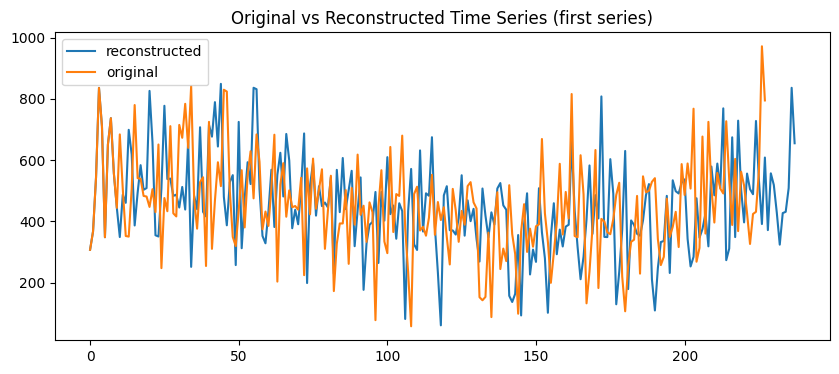

In [14]:
X_orig = create_dataset_vae.X_train_raw
X_hat_orig = X_hat

plt.figure(figsize=(10, 4))
plt.plot(X_hat_orig[:, 0], label="reconstructed")
plt.plot(X_orig[:, 0], label="original")
plt.legend()
plt.title("Original vs Reconstructed Time Series (first series)")
plt.show()


### **Cell 17: Define Transformation Configurations for Qualitative Visualization**

***

#### **Purpose**
This cell prepares a list of transformation configurations to be applied and visualized for qualitative assessment. Each entry specifies an augmentation method (such as "jitter" or "magnitude_warp") along with its parameters and benchmark settings, determining how augmented time series will be generated and compared.

***

#### **Detailed Notes**

- `transformations_plot = [...]`
  - Defines a list of dictionaries, where each dictionary describes a particular transformation to apply to the time series data for plotting/analysis.

- **First Dictionary** (`"jitter"` transformation)
    - `"transformation": "jitter"`
      - Selects random noise addition as the transformation.
    - `"params": [0.5, 0.5, 0.5, 0.5]`
      - Specifies the parameters for the jitter operation, possibly influencing noise intensity.
    - `"parameters_benchmark"`: `{ ... }`
      - Contains a sub-dictionary specifying the standard parameter values used for various transformation benchmarks.
      - Ensures results are comparable using standard settings for jitter, scaling, magnitude warp, and time warp.
    - `"version": 5`
      - Marks a version number for reference, useful if multiple transformation pipelines or settings are being compared.

- **Second Dictionary** (`"magnitude_warp"` transformation)
    - `"transformation": "magnitude_warp"`
      - Selects magnitude warp (smooth, nonlinear scaling of value ranges along the series) as augmentation.
    - `"params": [0.1, 0.1, 0.1, 0.1]`
    - `"parameters_benchmark": { ... }`
    - `"version": 4`
      - Similar to above, but different augmentation and version.

***

#### **Why This Matters**
- Prescribes exactly how the qualitative augmentation and visualization routines should behave—these settings are fed directly to the plotting and dataset generation functions in subsequent cells.
- Establishes reproducibility and clarity in transformation benchmarking by using carefully-chosen and repeated standard parameters.
- Key for visually and quantitatively assessing the effect of synthetic data augmentation on both the original and improved models.

***

**Summary:**  
This cell sets up a list of transformation configurations, specifying the methods, their parameters, and the benchmark settings to be used for generating augmented data and visualizing model output differences, forming the basis for qualitative side-by-side comparisons in the analysis pipeline.

In [15]:
transformations_plot = [
    {
        "transformation": "jitter",
        "params": [0.5, 0.5, 0.5, 0.5],
        "parameters_benchmark": {
            "jitter": 0.5,
            "scaling": 0.1,
            "magnitude_warp": 0.1,
            "time_warp": 0.05,
        },
        "version": 5,
    },
    {
        "transformation": "magnitude_warp",
        "params": [0.1, 0.1, 0.1, 0.1],
        "parameters_benchmark": {
            "jitter": 0.5,
            "scaling": 0.1,
            "magnitude_warp": 0.1,
            "time_warp": 0.05,
        },
        "version": 4,
    },
]


### **Cell 18: Visualize Effects of Time Series Data Transformations**

***

#### **Purpose**
This cell generates comparison plots showing how various augmentation techniques—specified in the previous cell—alter the original time series, as well as how the model reconstructs or generates new samples under these transformations. These plots are a critical qualitative tool for visually assessing the effect and plausibility of synthetic/augmented data generated by the improved model.

***

#### **Detailed Notes**

- `plot_transformations_with_generate_datasets(...)`
  - Calls the visualization function imported earlier to produce a series of plots, one for each transformation configuration specified.

  **Parameters:**
  - `dataset=dataset`
    - The dataset name (e.g., "tourism") indicates which data's transformations to visualize.
  - `freq=freq`
    - The time frequency (e.g., 'M' for monthly) to ensure time axes and seasonal splits are correct in the plots.
  - `generate_datasets=generate_datasets`
    - The function used to apply transformations and generate synthetic or reconstructed time series for plotting.
  - `X_orig=X_orig`
    - The original (untransformed) time series data to use as the visual ground truth.
  - `model=model`
    - The trained VAE model (CNN-GRU version) that will generate reconstructions or augmented series.
  - `z=z`
    - Latent variables computed from the model; used in generation or plotting synthetic samples.
  - `create_dataset_vae=create_dataset_vae`
    - The main object coordinating modeling and generation, allowing the visualization function to access all necessary preprocessing and inference routines.
  - `transformations=transformations_plot`
    - The list of transformations and parameters defined in the previous cell.
  - `num_series=4`
    - Specifies that the visualization should include four series per transformation in the overview plots—enough to see both typical and edge-case behavior.

***

#### **Why This Matters**
- Produces clear, publication-grade plots that illustrate the effect of different augmentation/warping techniques on original and model-generated time series.
- Allows for qualitative inspection: Are the synthetic outputs plausibly similar to the originals? Are they diverse, realistic, and representative?
- Helps reveal modeling weaknesses (e.g., over-smoothing, time-shifting, or failure to capture key structure in augmented data).

***

**Summary:**  
This cell produces side-by-side visual comparisons between original and transformed/generated series under specified augmentations, providing intuitive insight into both the model’s generative strengths and the impact of different synthetic data techniques.

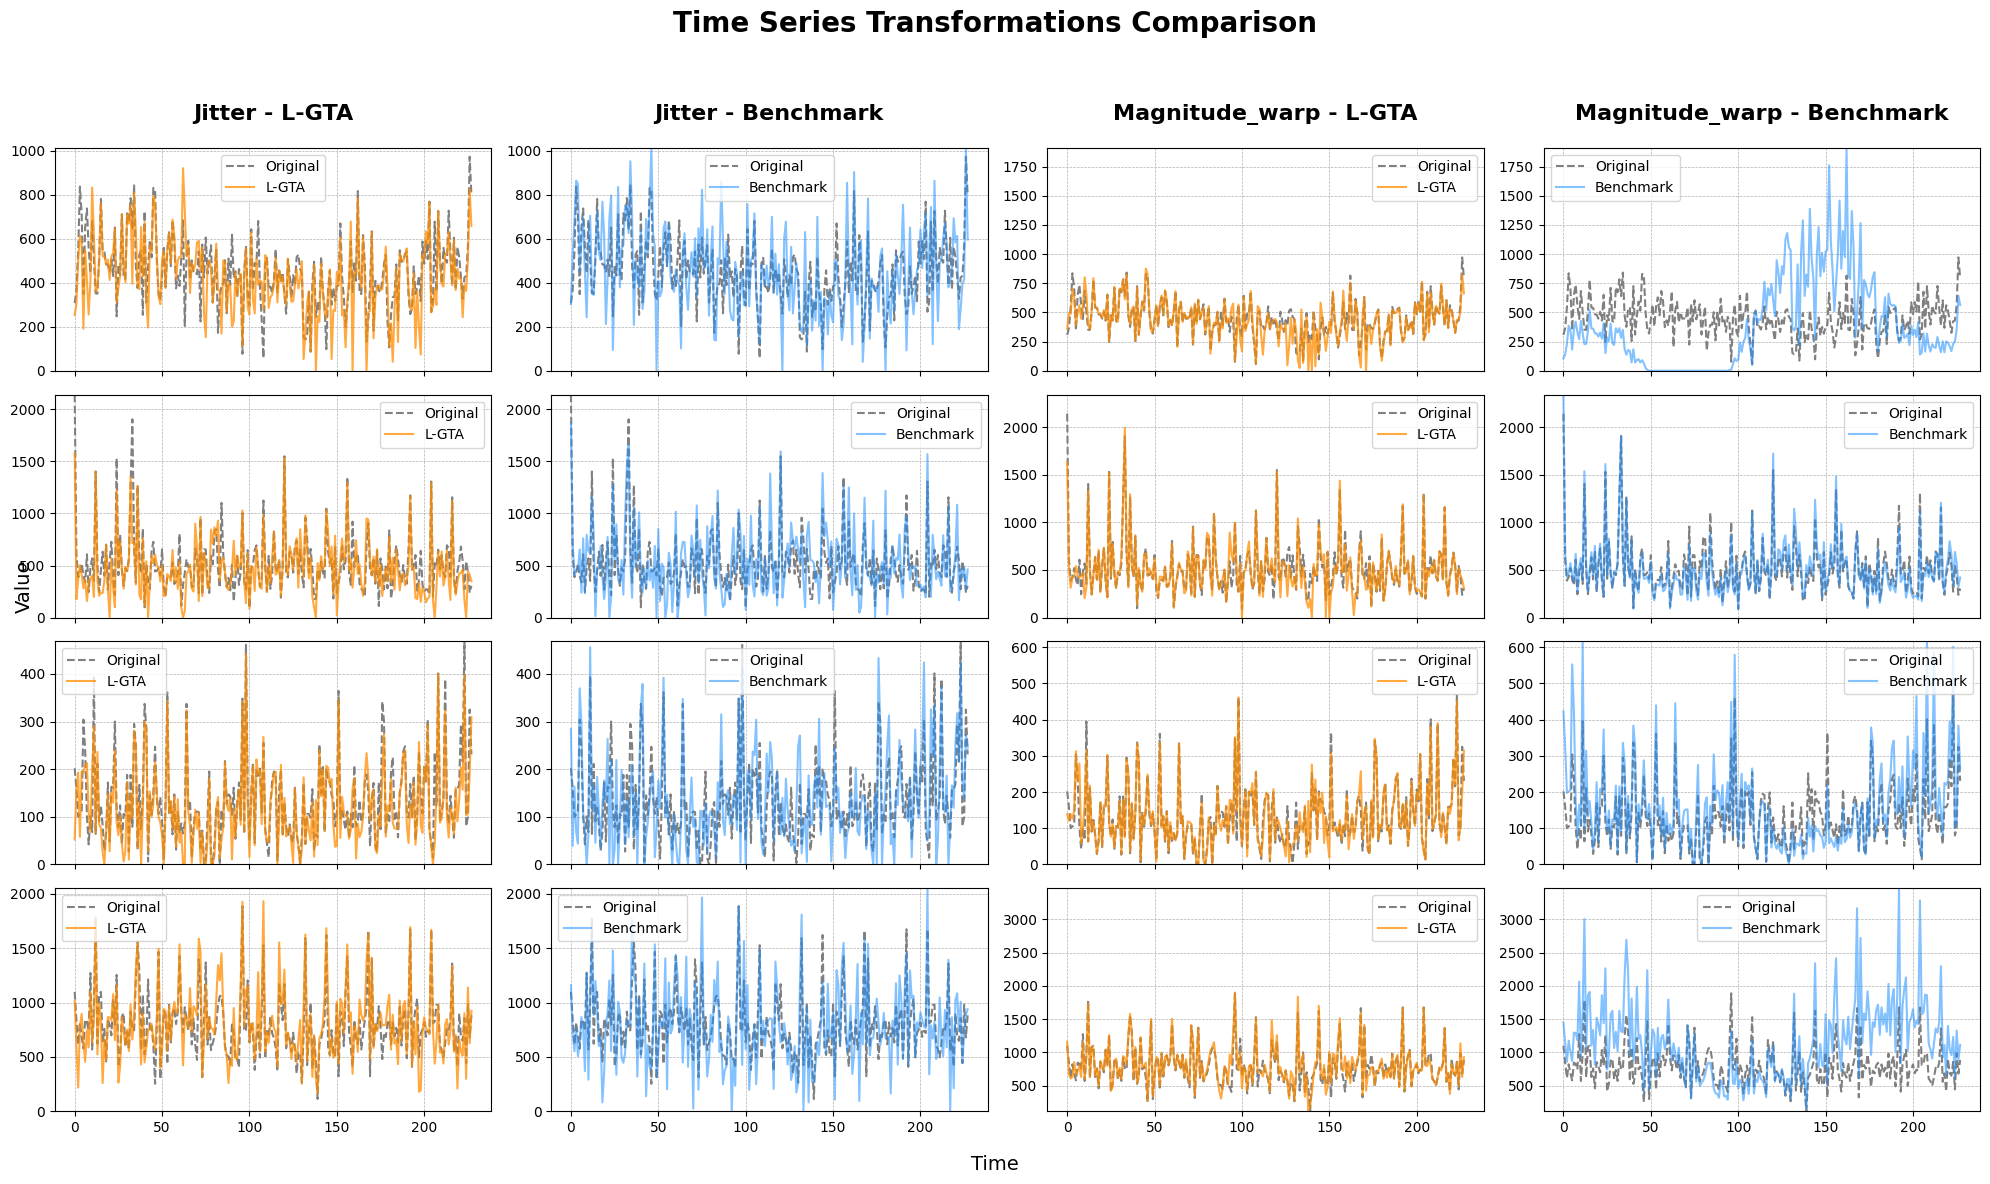

In [16]:
plot_transformations_with_generate_datasets(
    dataset=dataset,
    freq=freq,
    generate_datasets=generate_datasets,
    X_orig=X_orig,
    model=model,
    z=z,
    create_dataset_vae=create_dataset_vae,
    transformations=transformations_plot,
    num_series=4,
)


### **Cell 19: Compare the Magnitude Differences Between Original and Model-Generated Series**

***

#### **Purpose**
This cell computes and visualizes the differences in magnitude (scale, amplitude) between the original time series and the series produced by the generative model, typically across all or a subset of the data. The aim is to quantitatively and visually evaluate whether the improved VAE (CNN-GRU) architecture preserves key patterns, especially the magnitude variations, of the data after reconstruction or augmentation.

***

#### **Detailed Notes**

- `compare_diff_magnitudes(...)`
  - Calls a high-level utility (imported from the L-GTA workflow) designed for direct magnitude comparison between original and generated datasets.
  
  **Parameters:**
  - `dataset`
    - The name of the dataset (e.g., "tourism"); may be used for labeling or loading corresponding metadata.
  - `freq`
    - The frequency string ("M" for monthly, etc.), which ensures alignment when comparing periods or segments.
  - `model`
    - The trained generative model (CNN-GRU-based VAE) producing the reconstructions or augmentations for comparison.
  - `z`
    - The latent codes produced from the model, usually as the output from encoding the original data. These are used for generation, decoding, or variation in synthetic data.
  - `create_dataset_vae`
    - The primary orchestration object for model, data handling, and feature engineering throughout the workflow.
  - `X_orig`
    - The original time series data used as the quantitative “truth” in all comparisons.

***

#### **Why This Matters**
- Provides a quantitative and/or visual assessment of how well the generative model preserves one of the most important aspects of time series data: their magnitude or scaling structure across time.
- Vital for detecting issues such as the model consistently under- or over-estimating values, introducing bias, or smoothing away real variation.
- Useful in both academic and applied work: robust magnitude preservation is a critical component in credibility and trustworthiness of synthetic data.

***

#### **Expected Output**
- Visualizations (plots) and/or summary tables showing the degree of match or deviation between reconstructed and original series magnitudes.
- Statistical summaries capturing mean, variance, or distribution of magnitude errors.

***

**Summary:**  
This cell compares the magnitude of generated or reconstructed sequences to their original versions to assess the fidelity and reliability of the improved model in preserving scale and amplitude characteristics—an essential metric for time series generative modeling evaluation.

In [17]:
compare_diff_magnitudes(
    dataset,
    freq,
    model,
    z,
    create_dataset_vae,
    X_orig,
)


Output hidden; open in https://colab.research.google.com to view.

### **Cell 20: Define Main Experiment Augmentation Transformations**

***

#### **Purpose**
This cell defines a set of primary data augmentation transformations used for further **quantitative and qualitative experiments**. Each dictionary in the list encodes the specific transformation type, its core parameters, benchmark references, and a version identifier. This setup is essential for systematic analysis, comparison, and reproducibility of results involving synthetic time series generation.

***

#### **Detailed Notes**

- `transformations = [ ... ]`
  - Creates a list of dictionaries, where each dictionary defines a particular augmentation transformation to be applied to the original or generated time series.

- **For each transformation dictionary:**
    - `"transformation"`: Specifies the type of augmentation to be applied (possible values in this cell: `"jitter"`, `"scaling"`, `"magnitude_warp"`).
        - `"jitter"` adds random noise.
        - `"scaling"` multiplies the series by a scaling factor.
        - `"magnitude_warp"` applies smooth nonlinear warping to values.
    - `"params"`: The main numeric parameter for this augmentation (e.g. `[0.5]`, `[0.25]`, `[0.1]`). These control the intensity/degree of the transformation.
    - `"parameters_benchmark"`: Nested dictionary specifying standard/benchmark parameter values for all supported transformation types. This ensures all augmentations can be compared against reference settings used in related studies or published papers.
    - `"version"`: An integer versioning index for reference in results, figures, or data exports (useful if analyses are rerun or compared across settings).

***

#### **Why This Matters**
- Centralizes all experimental transformation settings, supporting systematic and reproducible analysis.
- Enables batch application and fair comparison across different augmentation schemes using preset, benchmarked parameters.
- These settings are directly referenced in all subsequent metric calculations and visualization functions, making this cell foundational for consistent results.

***

**Summary:**  
This cell defines the list of main synthetic data transformations—jitter, scaling, and magnitude warp—along with their critical parameters and reference benchmarks, ensuring all downstream experiments use the same augmentation strategy for reliable and reproducible model performance analysis.

In [18]:
transformations = [
    {
        "transformation": "jitter",
        "params": [0.5],
        "parameters_benchmark": {
            "jitter": 0.5,
            "scaling": 0.1,
            "magnitude_warp": 0.1,
            "time_warp": 0.05,
        },
        "version": 5,
    },
    {
        "transformation": "scaling",
        "params": [0.25],
        "parameters_benchmark": {
            "jitter": 0.375,
            "scaling": 0.1,
            "magnitude_warp": 0.1,
            "time_warp": 0.05,
        },
        "version": 4,
    },
    {
        "transformation": "magnitude_warp",
        "params": [0.1],
        "parameters_benchmark": {
            "jitter": 0.375,
            "scaling": 0.1,
            "magnitude_warp": 0.1,
            "time_warp": 0.05,
        },
        "version": 4,
    },
]


### **Cell 21: Run End-to-End Synthetic Data Pipeline for Each Transformation**

***

#### **Purpose**
This cell systematically applies each defined data augmentation transformation to the model and original data, running the entire end-to-end (E2E) workflow for **synthetic dataset generation, reconstruction, and metric calculation**. The results are collected into a dictionary for later evaluation, reporting, or visualization.

***

#### **Detailed Notes**

- `results = {}`
  - Initializes an empty dictionary to store the outputs of the E2E workflow for each transformation.

- `for transformation in transformations:`
  - Iterates through each transformation configuration previously defined in the `transformations` list.

- `results[transformation["transformation"]] = e2e_transformation(...)`
  - For each transformation:
    - Calls the `e2e_transformation` function, which:
        - Applies the augmentation to the dataset/model.
        - Generates synthetic samples or reconstructions.
        - Computes metrics, evaluations, and any relevant postprocessing steps.
    - The returned output (often a dictionary or structured result object) is stored in the `results` dictionary under a key named for the transformation type.
  - Arguments provided:
    - `dataset`: The current dataset name string.
    - `freq`: The time interval (e.g., "M" for monthly).
    - `model`: The trained, improved VAE (CNN-GRU) model.
    - `z`: Latent variables produced with the model.
    - `create_dataset_vae`: The handling object that coordinates augmentation and model inference.
    - `transformation["transformation"]`: Type of transformation (e.g., "jitter", "scaling", etc).
    - `transformation["params"]`: The key numeric parameter(s) for the augmentation.
    - `transformation["parameters_benchmark"]`: Reference (benchmark) parameters.
    - `transformation["version"]`: Version identifier for result tracking.
    - `X_orig`: The original data (for reference and comparison).
    - `X_hat`: The model’s reconstructed output (for error analysis).

***

#### **Why This Matters**
- Automates the entire process of testing synthetic data generation and model response for all core augmentation strategies in one loop.
- Provides a structured, easily-accessible dictionary with all necessary results for subsequent analysis, summary, export, or visualization.
- Ensures that each transformation is evaluated under the exact same conditions, allowing for fair and reproducible comparison.

***

**Summary:**  
This cell executes the complete synthetic data generation and evaluation pipeline for every transformation under study, collecting all outputs in a single results dictionary for organized downstream analysis.



In [19]:
results = {}
for transformation in transformations:
    results[transformation["transformation"]] = e2e_transformation(
        dataset,
        freq,
        model,
        z,
        create_dataset_vae,
        transformation["transformation"],
        transformation["params"],
        transformation["parameters_benchmark"],
        transformation["version"],
        X_orig,
        X_hat,
    )


Output hidden; open in https://colab.research.google.com to view.

### **Cell 22: Process Aggregated Experiment Results for Analysis**

***

#### **Purpose**
This cell takes the raw dictionary of results collected from running the end-to-end synthetic data and evaluation workflows (in the previous cell) and processes or structures them into a more analyzable, standardized format. This step usually flattens, cleans, or aggregates the data making it ready for quantitative comparison, summary statistics, and export.

***

#### **Detailed Notes**

- `res_processed = process_transformations(results)`
  - Calls the `process_transformations` function (imported from the L-GTA project's postprocessing utilities).
  - Passes in the `results` dictionary, which contains outputs from all transformations/augmentations (generated in cell 21).

- **What the function does:**
    - Converts the list/dictionary of raw outputs—potentially containing diverse result formats for each transformation—into a processed structure.
    - Unifies and standardizes data representations (e.g., error metrics, distances, model outputs, augmentation parameters), often converting to DataFrames or similar.
    - May calculate new fields, perform aggregation, normalization, or collapse per-series results into summary metrics.
    - Prepares results for easy export, further table-based analysis, plotting, or direct reporting.

***

#### **Why This Matters**
- Standardizes the result format so it can be fed directly into reporting, visualization, or statistical comparison routines.
- Reduces manual work in organizing metrics, ensuring consistency and reproducibility in downstream quantitative and qualitative evaluation.
- Serves as the bridge between experiment/augmentation runs and summary export or higher-level interpretation.

***

**Summary:**  
This cell processes and unifies all experimental results from multiple data transformation settings into a structured, analysis-ready format—enabling streamlined metric computation, comparison, and reporting in subsequent notebook cells.

In [20]:
res_processed = process_transformations(results)


### **Cell 23: Generate and Export Distance Metric Results**

***

#### **Purpose**
This cell computes and saves the **distance metrics** resulting from comparing original and generated (or transformed) time series. These metrics quantify the similarity or divergence between datasets using statistical or signal-based measures, providing key quantitative evidence of model and augmentation performance.

***

#### **Detailed Notes**

- `create_distance_metrics_dataset(res_processed)`
  - Calls the `create_distance_metrics_dataset` function, provided by the L-GTA postprocessing utilities.
  - Accepts the processed results (`res_processed`) obtained in the previous cell.
  - Computes distance- or dissimilarity-based metrics for each transformation/configuration.
    - Common distance metrics: Dynamic Time Warping (DTW), Euclidean, and others.
  - Exports or stores these metrics, often into a tabular structure (such as a Pandas DataFrame or CSV file), summarizing results for all transformations, models, and runs included in the `res_processed` container.

***

#### **Why This Matters**
- Distance-based metrics are essential for validating whether generated/augmented time series are plausible and sufficiently similar (but not identical) to the original data.
- These metrics are typically included in tables or figures in publications to compare augmentation and model effectiveness quantitatively across methods.
- Exporting them ensures results are available for further analysis, sharing, or inclusion in reports.

***

**Summary:**  
This cell calculates and saves key distance metrics between original and synthetic data for all transformations performed, enabling thorough quantitative evaluation of both model fidelity and augmentation diversity.

In [21]:
create_distance_metrics_dataset(res_processed)


Method-Transformation,L-GTA - jitter,Benchmark - jitter,L-GTA - magnitude_warp,Benchmark - magnitude_warp,L-GTA - scaling,Benchmark - scaling
Metric,,,,,,
Wasserstein Median,0.102,0.184,0.064,0.193,0.172,0.135
Wasserstein Iqr,0.076,0.061,0.038,0.194,0.145,0.110


### **Cell 24: Generate and Export Reconstruction Error Percentage Results**

***

#### **Purpose**
This cell computes and saves the **reconstruction error percentages**, summarizing how accurately the improved model (with all applied transformations) can reproduce the original time series from their latent or augmented representations. This is a crucial quantitative metric for assessing the fidelity of generative models and augmentation processes.

***

#### **Detailed Notes**

- `create_reconstruction_error_percentage_dataset(res_processed)`
  - Calls the `create_reconstruction_error_percentage_dataset` function from the L-GTA postprocessing module.
  - Processes `res_processed`, which contains the results for all transformations, to calculate the percentage error between the model's reconstructions and the original data.
      - Reconstruction error percentages typically measure the absolute or squared difference as a percentage of the true value, normalized over all time points.
  - The result—often a DataFrame or CSV—facilitates comparison across models, parameter settings, or data splits.

***

#### **Why This Matters**
- This metric provides an easily interpretable summary of model accuracy, indicating what fraction of the data the model reconstructs well vs. where substantial error remains.
- Useful for ranking the effectiveness of generative models, quantifying improvement over baselines, and summarizing results in tables/figures for papers or reports.
- Exporting these results allows for subsequent statistical analysis, easier visualizations, and supports direct reproducibility.

***

**Summary:**  
This cell calculates and exports the error percentages between original and reconstructed time series across all studied transformations, delivering a vital performance indicator for generative and augmentation models.

In [22]:
create_reconstruction_error_percentage_dataset(res_processed)


Transformation,jitter,magnitude_warp,scaling
Model,,,
L-GTA,100.9,97.3,126.6
Benchmark,168.4,170.6,250.9


### **Cell 25: Generate and Export Prediction Comparison Results**

***

#### **Purpose**
This cell creates a dataset or table that enables direct comparison between the predicted (reconstructed or augmented) time series and the true/original time series across all transformations and settings. This consolidated structure supports in-depth analysis and visualization of model performance.

***

#### **Detailed Notes**

- `create_prediction_comparison_dataset(res_processed)`
  - Calls the `create_prediction_comparison_dataset` function from the L-GTA postprocessing toolkit.
  - Takes the processed collective results (`res_processed`) containing all transform/model combinations.
  - Creates a unified comparison dataset, likely tabular, that aligns model predictions with the corresponding original values for each point, series, and transformation.
  - This result makes it straightforward to:
      - Calculate summary statistics or error metrics.
      - Generate side-by-side or difference plots.
      - Profile model performance on individual series or across aggregate sets.

***

#### **Why This Matters**
- Having a consolidated prediction vs. truth dataset is critical for generating custom metrics, advanced visualizations, and reporting per-series or per-group performance.
- Facilitates objective, quantitative benchmarking between various augmentation or modeling approaches.
- Ready-made inputs for further notebook cells (e.g., boxplots, error histograms, time slices) or for external tools.

***

**Summary:**  
This cell creates and exports a dataset aligning model predictions with corresponding original values for all experiments conducted, streamlining comprehensive quantitative comparison and deeper analysis of reconstruction or augmentation effectiveness.

In [23]:
create_prediction_comparison_dataset(res_processed)


Transformation,jitter,magnitude_warp,scaling
Model,,,
Original,0.022,0.023,0.022
L-GTA,0.022,0.023,0.023
Benchmark,0.023,0.024,0.026


### **Cell 26: Define Specific Transformation Settings for Focused Analysis**

***

#### **Purpose**
This cell specifies the parameters for a **focused analysis or detailed benchmark** involving the "jitter" transformation. By isolating individual transformation settings, the next cells can analyze model/augmentation behavior with tailored metrics or visualizations for specific cases.

***

#### **Detailed Notes**

- `transformation = "jitter"`
  - Selects "jitter" (random noise injection) as the augmentation method for this specific analysis.

- `params = [0.5]`
  - Sets the jitter (noise) parameter to 0.5. This controls the intensity/variance of the noise added to the original series.

- `parameters_benchmark = { ... }`
  - Provides a nested dictionary dictating standard benchmark parameter values for all related augmentation types (not only jitter, but also scaling, magnitude_warp, and time_warp). These ensure reproducibility and clear documentation for comparison with related work or ablation studies.

- `version = 5`
  - Assigns a version number, allowing for traceability or reference in results. Versioning helps distinguish between different settings in complex experiments or repeated runs.

***

#### **Why This Matters**
- Targeted parameterization enables per-transformation, per-setting analysis, which supports:
  - Fine-grained evaluation (e.g., error distribution or metric breakdown just for jitter=0.5).
  - Isolation of effects or failure cases for publication-quality figures and tables.
  - Consistency with reported results in literature or internal benchmarks.

***

**Summary:**  
This cell sets up single-case parameters for performing a focused, detailed analysis of the "jitter" transformation with magnitude 0.5, along with associated benchmark parameters for transparency and consistent documentation.



In [24]:
transformation = "jitter"
params = [0.5]

parameters_benchmark = {
    "jitter": 0.5,
    "scaling": 0.1,
    "magnitude_warp": 0.1,
    "time_warp": 0.05,
}

version = 5


### **Cell 27: Generate Data for Targeted Transformation Analysis**

***

#### **Purpose**
This cell runs the synthetic data generation pipeline for the selected transformation settings (from the previous cell), producing three sets of data: the original, the model-generated (L-GTA), and the benchmark transformation output. This enables direct, quantitative comparison and error analysis focused on a specific augmentation experiment.

***

#### **Detailed Notes**

- `X_orig, X_lgta, X_benchmark = generate_datasets(...)`
  - Calls the `generate_datasets` function from L-GTA, using parameters that correspond to the specific transformation setup defined earlier.
  - Returns three aligned datasets:
    - `X_orig`: The original, unaugmented time series data, providing the ground truth reference.
    - `X_lgta`: The time series generated or reconstructed by the improved L-GTA model (CNN-GRU).
    - `X_benchmark`: The output produced by the benchmark transformation (using reference parameters), which may use standard data augmentation or competing method for comparison.

  **Arguments Passed:**
  - `dataset, freq`: Specifies data source and time frequency.
  - `model, z, create_dataset_vae`: Passes the model and its latent variables along with the orchestration object for full-generation functionality.
  - `X_orig`: Source series used for transformation.
  - `transformation, params, parameters_benchmark, version`: Specifies which transformation, key parameter, benchmark settings, and a version tag for tracking results.

***

#### **Why This Matters**
- Produces the key datasets needed for:
    - Residual/error analysis.
    - Visual side-by-side comparison and qualitative assessment.
    - Quantitative benchmarking against standard augmentation methods and the model’s own synthetic series.

***

**Summary:**  
This cell synthesizes the original, model-generated, and benchmark time series data for a specified transformation, enabling the next steps of error calculation, visual comparison, and detailed performance analysis for that augmentation scenario.

In [25]:
X_orig, X_lgta, X_benchmark = generate_datasets(
    dataset,
    freq,
    model,
    z,
    create_dataset_vae,
    X_orig,
    transformation,
    params,
    parameters_benchmark,
    version,
)


### **Cell 28: Calculate Standardized Residuals for Model and Benchmark**

***

#### **Purpose**
This cell measures the error—specifically, the **standardized residuals**—between the original series and both the L-GTA model output and the benchmark output for the chosen transformation. Such residuals allow for objective, quantitative comparison of reconstruction or augmentation quality.

***

#### **Detailed Notes**

- `residuals_lgta, residuals_benchmark = standardize_and_calculate_residuals(X_orig, X_lgta, X_benchmark)`
  - Calls the `standardize_and_calculate_residuals` function, previously imported from the L-GTA evaluation module.
  - Compares:
    - Original series (`X_orig`)
    - Series generated by the improved model (`X_lgta`)
    - Outputs from the benchmark augmentation (`X_benchmark`)
  - Calculates the **residuals**: the differences (errors) between `X_orig` and each reconstructed/augmented version.
  - Standardizes those errors, typically by normalizing with some measure of variability (e.g., by mean or standard deviation of the original), so that results are comparable regardless of series scale or variance.

- Returns:
    - `residuals_lgta`: The standardized errors between `X_orig` and the L-GTA output.
    - `residuals_benchmark`: Standardized errors between `X_orig` and the benchmark output.

***

#### **Why This Matters**
- Standardized residuals are foundational for model evaluation—lower residuals mean better reconstruction (or augmentation) fidelity.
- Enables objective comparison between different treatments or methods, independent of the raw value scale.
- These values are used in reporting (e.g., boxplots, error tables) and as direct metrics for benchmarking.

***

**Summary:**  
This cell computes and standardizes the reconstruction or augmentation errors for both the improved L-GTA model and a benchmark transformation, providing the quantitative foundation for outcome comparison and deeper analysis in subsequent steps.



In [26]:
residuals_lgta, residuals_benchmark = standardize_and_calculate_residuals(
    X_orig, X_lgta, X_benchmark
)


### **Cell 29: Visualize Series Comparisons for Selected Transformation**

***

#### **Purpose**
This cell produces plots that visually compare the original series, the reconstructed series from the improved L-GTA model, and the benchmark-transformed series under the "jittering" augmentation. The visualization supports direct qualitative evaluation of how each method preserves or alters the time series structure.

***

#### **Detailed Notes**

- `plot_series_comparisons(X_orig, X_lgta, X_benchmark, "jittering")`
  - Calls the `plot_series_comparisons` function, a specialized visualization tool from the L-GTA framework.
  - Inputs:
    - `X_orig`: Original, unmodified time series data.
    - `X_lgta`: Time series produced by the improved L-GTA model.
    - `X_benchmark`: Series generated by the benchmark transformation.
    - `"jittering"`: A descriptive label for the transformation shown in the plot (typically added to titles or legends).
  - Outputs one or more visualizations:
    - Overlays of original, model-generated, and benchmark series on the same axes.
    - Individual or groupwise comparison plots (may support batch/ensemble visualization by series).
    - Legends and titles indicate which method produced each series.

***

#### **Why This Matters**
- Visual comparisons are essential for demonstrating reconstruction quality and intuitively evaluating whether augmented or generated series "look right."
- Helps spot model weaknesses, such as systematic bias, oversmoothing, overfitting, or unrealistic synthetic data patterns.
- Supports both in-notebook inspection and later report figure generation.

***

**Summary:**  
This cell creates direct visualizations of original, model-generated, and benchmark series for the "jittering" transformation, enabling qualitative assessment of each method’s ability to preserve genuine time series structure under augmentation.



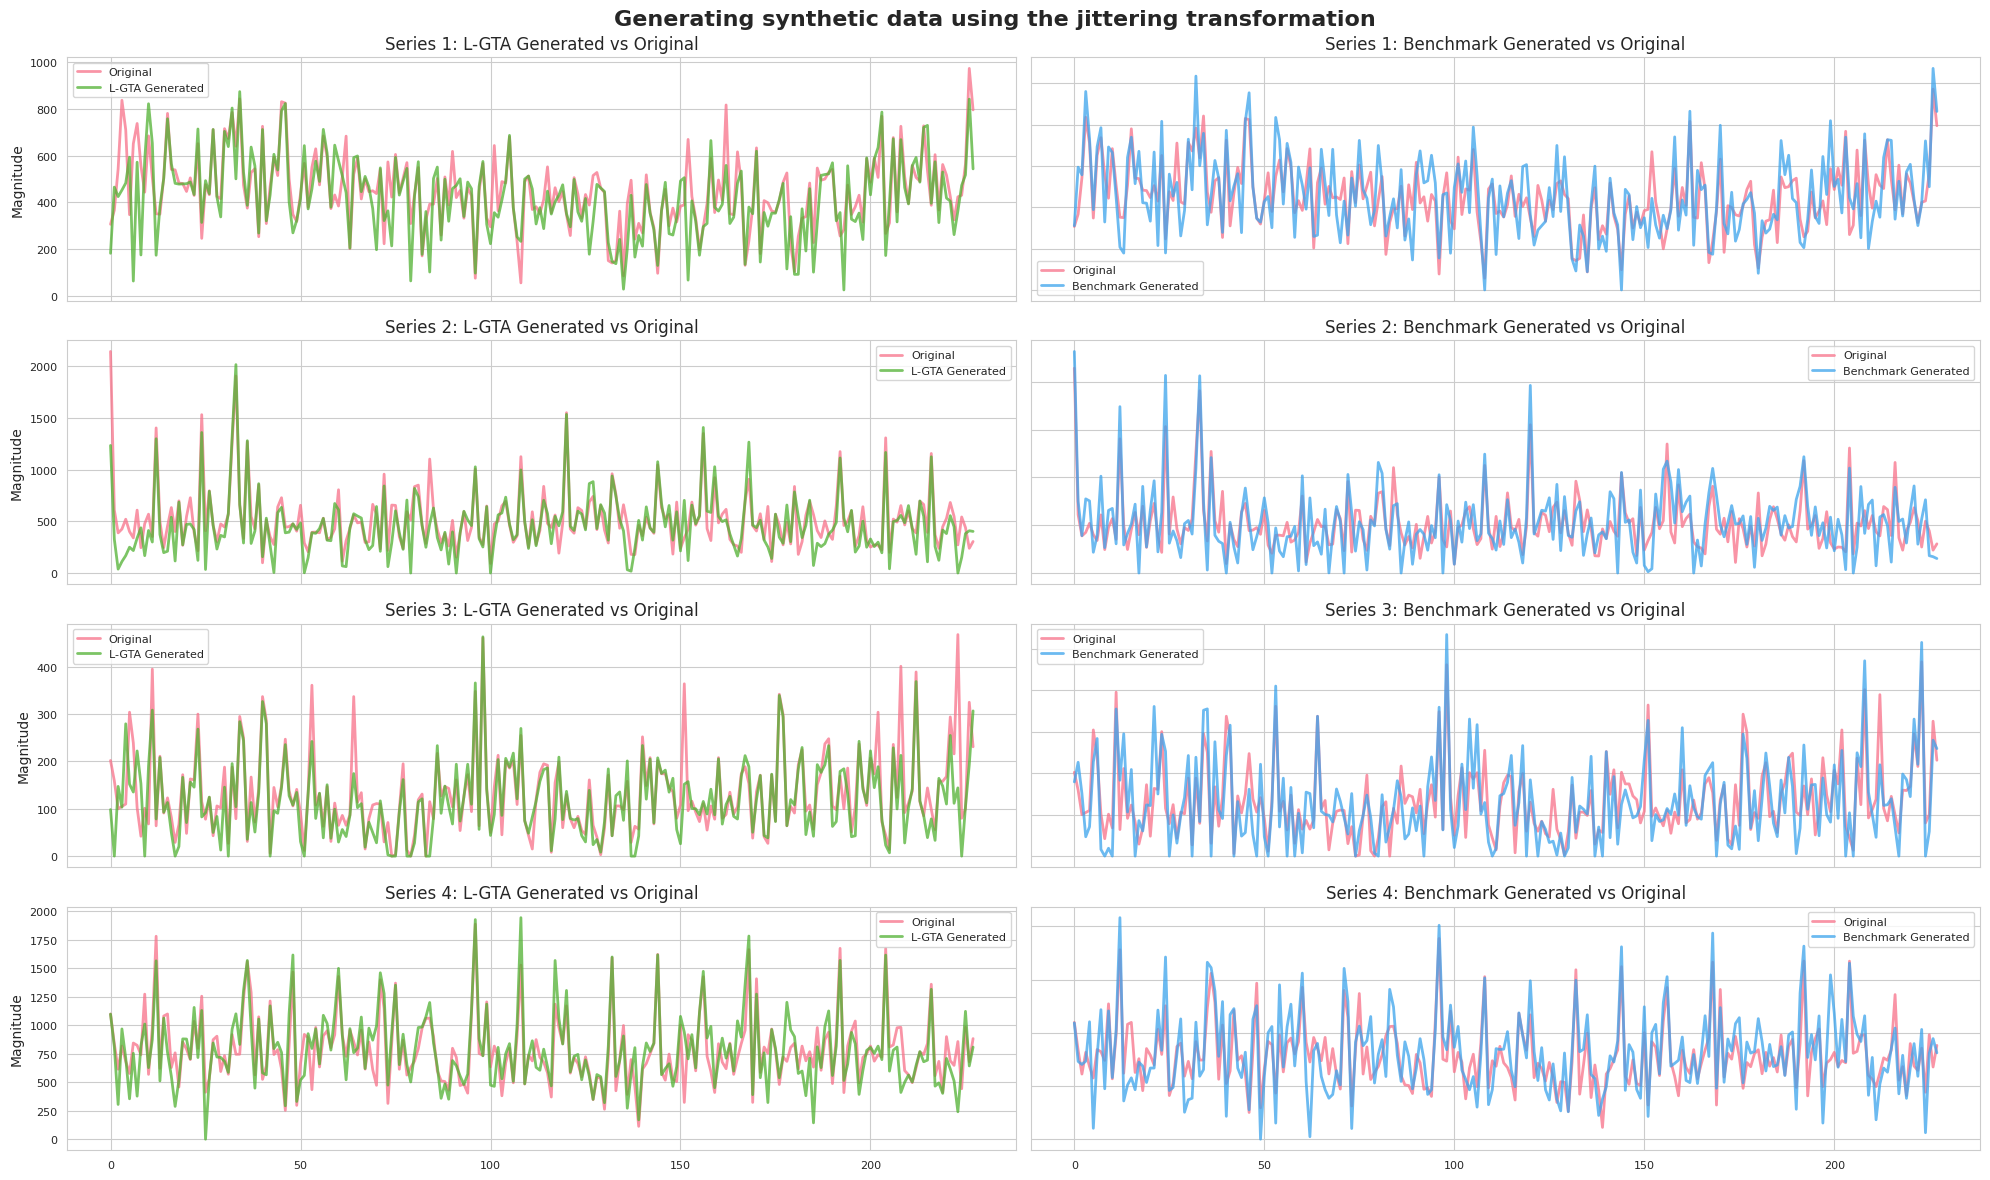

In [27]:
plot_series_comparisons(X_orig, X_lgta, X_benchmark, "jittering")


### **Cell 30: Statistical Analysis of Transformation Residuals**

***

#### **Purpose**
This cell conducts a statistical analysis of the residuals (errors) for both the L-GTA model and the benchmark transformation, providing quantitative summary statistics and deeper insight into reconstruction or augmentation performance for the selected transformation.

***

#### **Detailed Notes**

- `analyze_transformations(residuals_lgta, residuals_benchmark)`
  - Calls the `analyze_transformations` function from the evaluation toolkit of L-GTA.
  - Inputs:
    - `residuals_lgta`: Standardized residuals between original series and output from the L-GTA model.
    - `residuals_benchmark`: Standardized residuals between original series and output from the benchmark transformation.
  - The function:
    - Computes sample statistics (mean, standard deviation, percentiles, etc.) of error for each method.
    - May output tabular summaries, print comparative analysis, produce boxplots, or display error histograms.
    - Supports comparative reporting: quickly highlights whether the improved model outperforms, matches, or underperforms the benchmark on a selected transformation.

***

#### **Why This Matters**
- Quantitative error statistics underpin objective model evaluation and comparison.
- These metrics can be cited in reports and publications, supporting statistical significance claims or comparative analysis.
- Reveals not only average performance but also distribution—e.g., whether errors are consistent, skewed, or dominated by outliers.

***

**Summary:**  
This cell analyzes and summarizes the standardized error distributions for both the model and transformation outputs, delivering quantitative evidence to support performance claims and deeper understanding of method strengths or limitations.

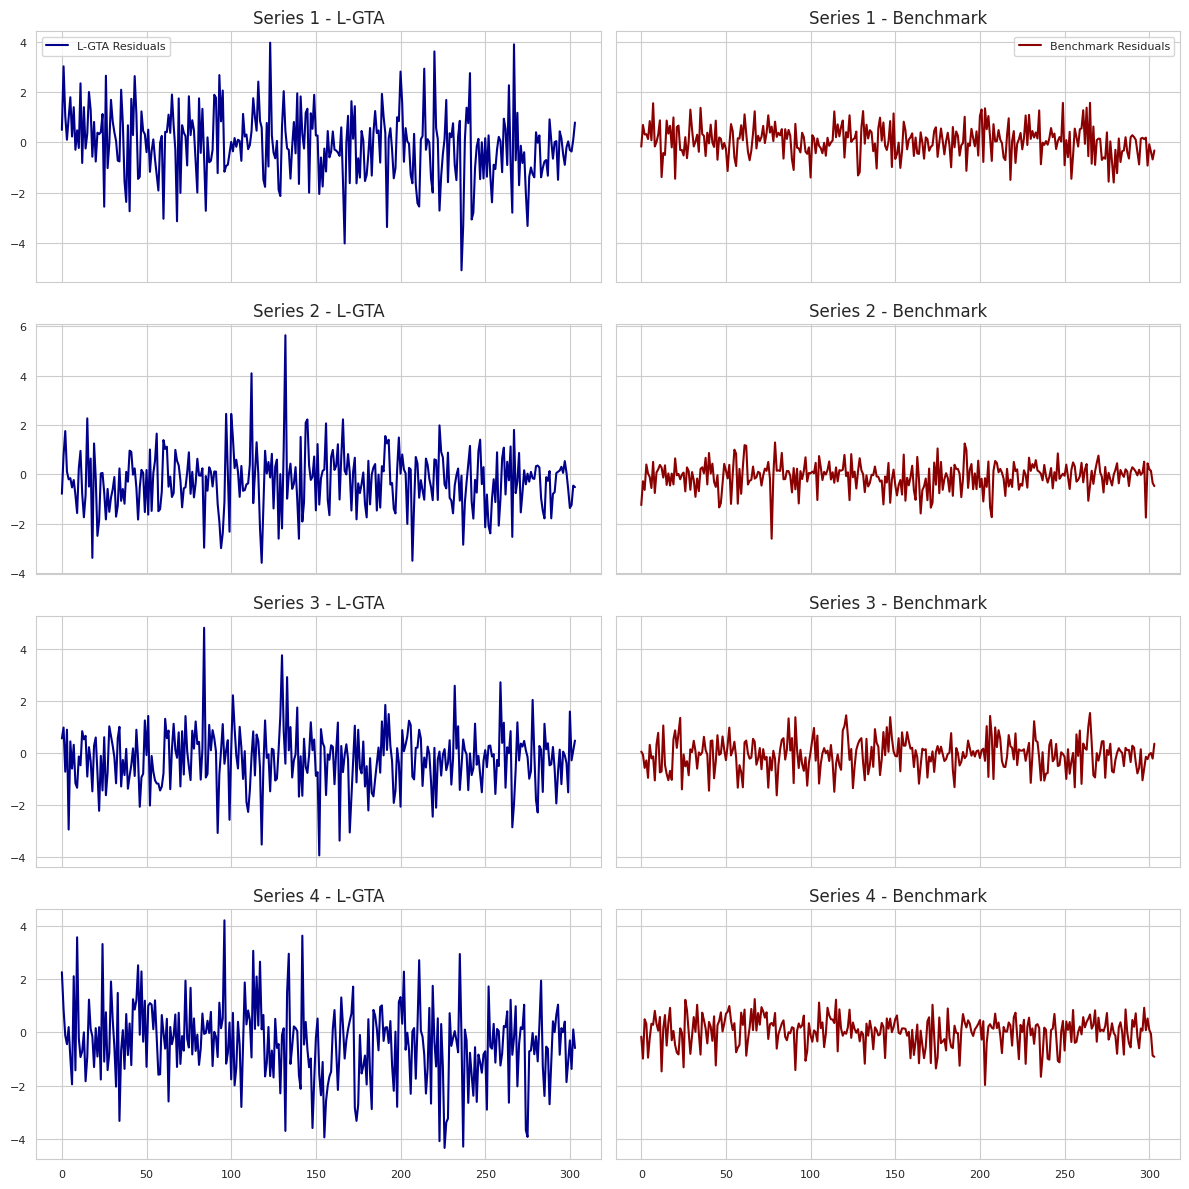

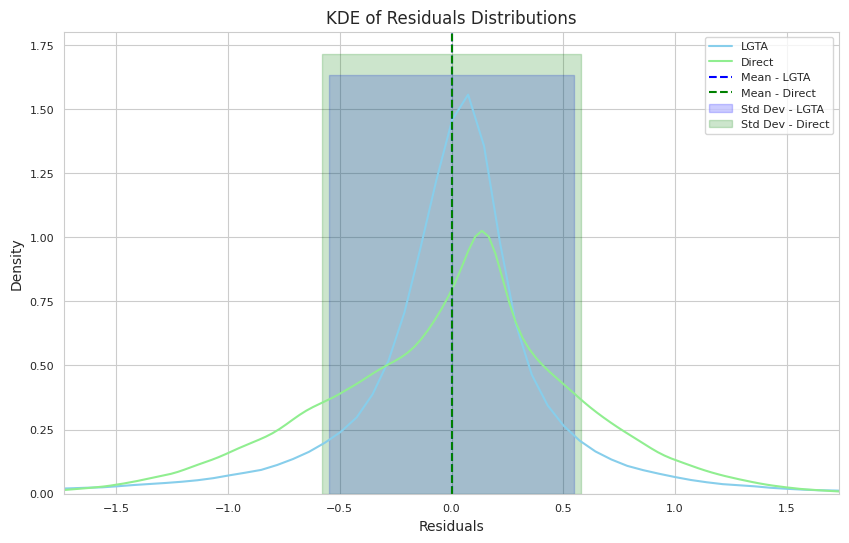

In [28]:
analyze_transformations(residuals_lgta, residuals_benchmark)


### **Cell 31: Multi-Parameter Setup for Gradient Analysis of Jitter Transformation**

***

#### **Purpose**
This cell sets up the parameter space for a gradient or sensitivity analysis focused on the "jitter" transformation, preparing to systematically evaluate how changing the transformation intensity affects model and benchmark residuals. Lists and arrays are initialized to aggregate results for each setting.

***

#### **Detailed Notes**

- `transformation = "jitter"`
  - Specifies that the upcoming loop and analysis will focus on the "jitter" augmentation technique (noise injection).

- `params = [0.5, 0.6, 0.7, 0.8, 0.9]`
  - Defines a sequence of jitter intensity levels for systematic exploration. Each value controls the amount of noise added.

- `parameters_benchmark = [...]`
  - Supplies a list of benchmark parameter dictionaries corresponding to each `params` value, ensuring each trial uses a well-documented, reproducible reference configuration.
  - Each benchmark dictionary includes standard values for all related transformation parameters, not just jitter.

- `version = 5`
  - Sets a version number for traceability in result files and analysis plots.

- `residuals_lgta_all = []`
  - Initializes an empty list for storing standardized residuals between original and model-generated series for each jitter level.

- `residuals_benchmark_all = []`
  - Initializes a corresponding list for benchmark residuals by jitter level.

***

#### **Why This Matters**
- Structures parameter sweeps and ablation studies, enabling the notebook to collect results across a range of transformation intensities in a systematic, comparable way.
- Facilitates trend detection: understanding how model reconstruction error or transformation fidelity changes as augmentation magnitude increases.

***

**Summary:**  
This cell prepares a sequence of jitter parameters and corresponding benchmark settings for gradient or multi-level analysis, enabling thorough aggregation and later visualization of performance across varying augmentation intensities.

In [29]:
transformation = "jitter"
params = [0.5, 0.6, 0.7, 0.8, 0.9]

parameters_benchmark = [
    {"jitter": 0.5, "scaling": 0.1, "magnitude_warp": 0.1, "time_warp": 0.05},
    {"jitter": 0.6, "scaling": 0.1, "magnitude_warp": 0.1, "time_warp": 0.05},
    {"jitter": 0.7, "scaling": 0.1, "magnitude_warp": 0.1, "time_warp": 0.05},
    {"jitter": 0.8, "scaling": 0.1, "magnitude_warp": 0.1, "time_warp": 0.05},
    {"jitter": 0.9, "scaling": 0.1, "magnitude_warp": 0.1, "time_warp": 0.05},
]

version = 5

residuals_lgta_all = []
residuals_benchmark_all = []


### **Cell 32: Loop Over Jitter Magnitudes for Gradient Analysis**

***

#### **Purpose**
This cell systematically applies the "jitter" transformation across a range of parameter values, computes the standardized residuals for both model and benchmark, and aggregates the results for detailed trend and sensitivity analysis. The setup enables visualization of how model and benchmark performance degrade or improve as transformation intensity changes.

***

#### **Detailed Notes**

- `for i, param in enumerate(params):`
  - Iterates over each jitter value defined in `params` (from cell 31), using its position `i` to index into both the benchmark parameters and to tag the result.

- Within the loop:
    - `X_orig, X_lgta, X_benchmark = generate_datasets(...)`
      - Generates synthetic, reconstructed, and benchmark series for the current jitter parameter.
      - Uses the correct benchmark parameter dictionary for each trial (`parameters_benchmark[i]`).

    - `residuals_lgta, residuals_benchmark = standardize_and_calculate_residuals(X_orig, X_lgta, X_benchmark)`
      - Calculates the standardized errors for both model output and benchmark transformation at the current jitter level.

    - `residuals_lgta_all.append(residuals_lgta)`
      - Aggregates model errors for all series into a list for gradient analysis.

    - `residuals_benchmark_all.append(residuals_benchmark)`
      - Aggregates benchmark errors correspondingly.

***

#### **Why This Matters**
- Automatically builds up a detailed record of how both methods behave across increasing noise—essential for diagnosing sensitivity, robustness, and generalization performance.
- Supports downstream plotting and trend analysis (e.g., boxplots, error curves vs. augmentation intensity).
- Enables fair, transparent side-by-side evaluation of the improved model and benchmark at all tested augmentation levels.

***

**Summary:**  
This cell executes a performance sweep across several jitter magnitudes, producing comprehensive error datasets for both model and benchmark series and setting the stage for subsequent comparative trend visualization and analysis.

In [30]:
for i, param in enumerate(params):
    X_orig, X_lgta, X_benchmark = generate_datasets(
        dataset,
        freq,
        model,
        z,
        create_dataset_vae,
        X_orig,
        transformation,
        [param],
        parameters_benchmark[i],
        version,
    )
    residuals_lgta, residuals_benchmark = standardize_and_calculate_residuals(
        X_orig, X_lgta, X_benchmark
    )
    residuals_lgta_all.append(residuals_lgta)
    residuals_benchmark_all.append(residuals_benchmark)


### **Cell 33: Visualize Error Gradient Across Jitter Intensities**

***

#### **Purpose**
This cell plots how the residuals (errors) of both the improved model and the benchmark change as the magnitude of the "jitter" transformation increases. The resulting visualization reveals patterns or trends in sensitivity and robustness, making it easy to compare performance under stronger data augmentation.

***

#### **Detailed Notes**

- `plot_residuals_gradient(residuals_lgta_all, residuals_benchmark_all, params)`
  - Calls the `plot_residuals_gradient` function from L-GTA’s evaluation/visualization module.
  - Inputs:
    - `residuals_lgta_all`: List of residual arrays for the model’s output, with one entry per jitter parameter.
    - `residuals_benchmark_all`: List of residual arrays for the benchmark output, in the same order.
    - `params`: Sequence of jitter strengths corresponding to each residuals array pair.
  - Generates a set of plots (usually grouped boxplots or line plots):
    - X-axis: Jitter intensity.
    - Y-axis: Aggregated error/residual metric (mean, median, spread etc.).
    - Provides intuitive, quantitative visualization of how model and benchmark performance degrade or stabilize under increasing noise.

***

#### **Why This Matters**
- Allows for immediate spotting of performance cliffs, points of robustness loss, or ranges where the improved model outperforms/matches/is worse than the benchmark.
- Such gradient or trend visualizations are essential in research reports to substantiate claims of robustness, generalizability, or breakdown scenarios.
- Takes advantage of multi-parameter setup and looping from previous cells, summarizing a key dimension of model behavior in one figure.

***

**Summary:**  
This cell generates a visual comparison of error trends for model and benchmark series as jitter magnitude varies, offering clear insight into performance stability and sensitivity across a range of data augmentation intensities.



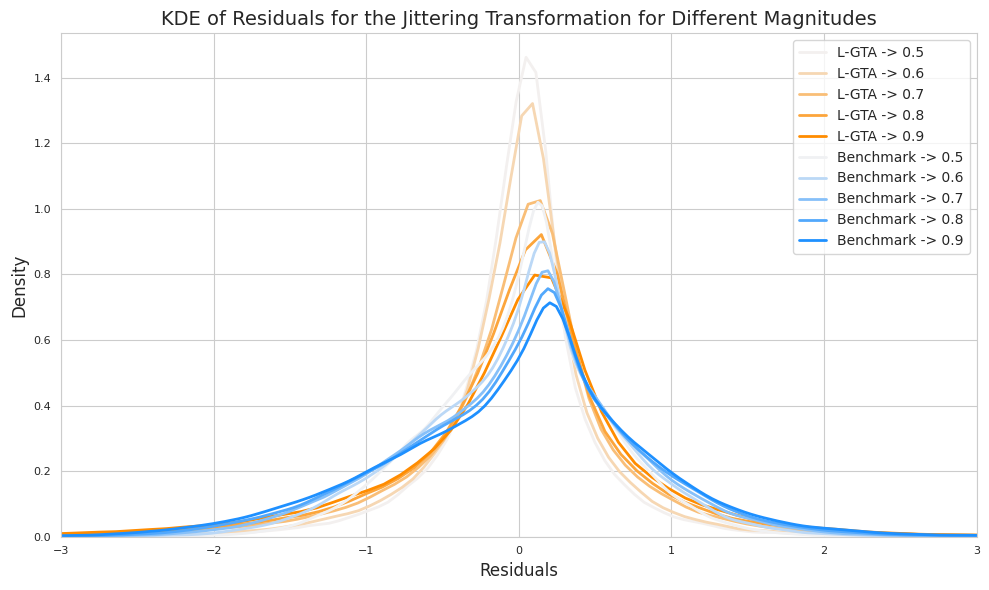

In [31]:
plot_residuals_gradient(residuals_lgta_all, residuals_benchmark_all, params)


In [35]:
from google.colab import drive
drive.mount('/content/drive')

In [36]:
!cp /content/L_GTA_IMPROVED.ipynb /content/drive/MyDrive/

In [37]:
!cp -r /content/latent-generative-modeling-time-series-augmentation /content/drive/MyDrive/